## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [34]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('./data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


## 1. Exploratory Data Analysis
### 1.1 Preprocessing

In [35]:
# Encoding the Promotion Feature for 0 as No and 1 as Yes
train_data["Promotion"] = train_data["Promotion"].replace({"No": 0, "Yes": 1})

In [36]:
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [37]:
# Checking number of samples if data is imbalanced

train_data["Promotion"].value_counts()
train_data["purchase"].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

There is an class imbalanced in the purchase feature much more customers did not make a purchase than they did. We can try to use stratification to try to help remedy this and resample.

In [38]:
# Summary of the dataset
train_data.describe()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.501147,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.500002,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,1.000000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,1.000000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


<AxesSubplot:>

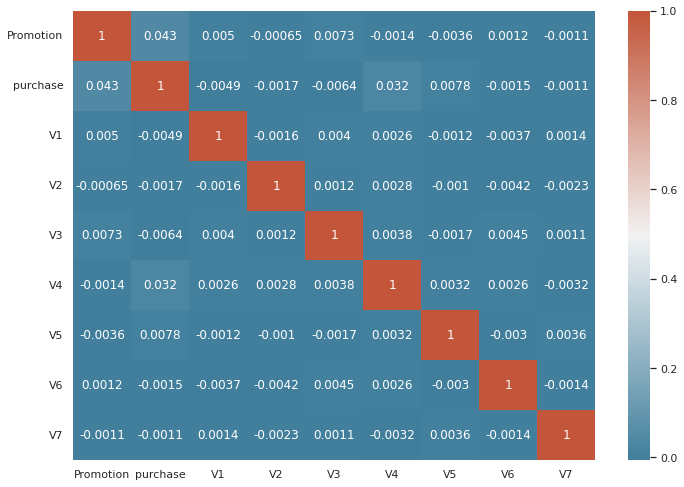

In [39]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Visualizing correlations
sns.set_theme(style="white")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(train_data.iloc[:,1:].corr(), annot=True, cmap=cmap)

#### Correlation Matrix
There is a 0.043 correlation coefficient between promotion and purchase which is higher than the other features. V4 feature seems to affect purchasing decision. Thus leveraging this we can say looking at V4 will be helpful in swaying customers to purchase.

TODO: Try to see if we can group certain customers by V3 and V1 with a scatterplot and k nearest neighbors model

### 1.2 Identifying effect of Treatment on Product purchase and Net Incremental Revenue

To address the first question: 

Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue

TODO: Seperate out customers that have seen the promotion and bought and target those people.

In [40]:
# Splitting into control which does not have the promotion and treatment which contains customers that have seen the promotion

control = train_data[train_data['Promotion']==0]
treatment = train_data[train_data['Promotion']==1]

# Checking to make sure number of promotions is balanced (Which they are)
train_data['Promotion'].value_counts()

1    42364
0    42170
Name: Promotion, dtype: int64

Control: # of purchases 319
Treatment: # of purchases 721


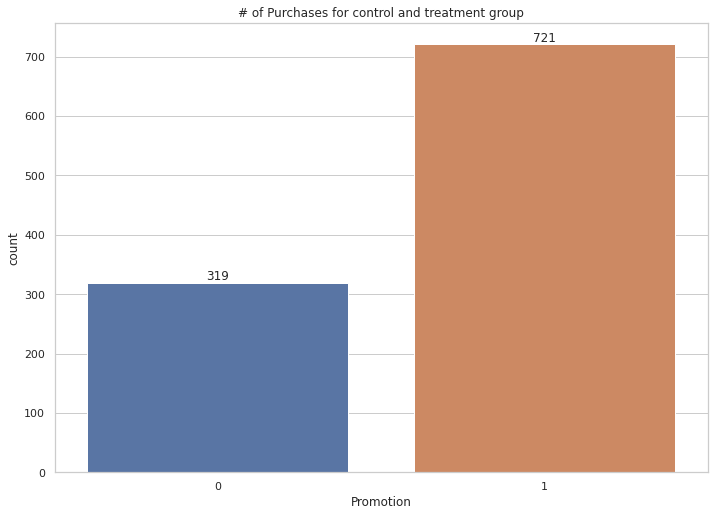

In [41]:
# Seeing how many purchases in each group
control_purchases = control['purchase'].sum()
treatment_purchases = treatment['purchase'].sum()

print("Control: # of purchases", control_purchases)
print("Treatment: # of purchases", treatment['purchase'].sum())

# Visualizing 
sns.set_theme(style="whitegrid")
fig = sns.countplot(data=train_data[train_data['purchase']==1], x="Promotion", capsize=.2)
fig.set_title("# of Purchases for control and treatment group")
fig.bar_label(fig.containers[0], labels=[control_purchases, treatment_purchases])
plt.show()

### 1.3 Statistical Hypothesis Test
In order to evaluate if there is a statistical signifiance in purchases between the control and treatment group. We can conduct a binom test to evaluate the success rate between the two groups.

In [42]:
from scipy.stats import binomtest

# For the binom test we need to calculate the probability of success in our control group. The number of purchases divided by the number of trials
control_p = control_purchases / len(control)

result = binomtest(k=treatment_purchases, n=len(treatment), p=control_p)

print("Control Purchase Probability: ", control_p)
print("P-value: ", result.pvalue)
print("Treatment Probability Estimate: ", result.proportion_estimate)
print("Treatment Probability Confidence Interval: ", result.proportion_ci(confidence_level=0.95))


Control Purchase Probability:  0.007564619397676073
P-value:  5.912424622466655e-83
Treatment Probability Estimate:  0.017019167217448776
Treatment Probability Confidence Interval:  ConfidenceInterval(low=0.01580888988048724, high=0.018296271508151336)


#### Results of the Binom Test
The control purchase probability is 0.007 while the treatment probability estimate is ~0.01709 with an confidence interval of (0.0158, 0.0183) with 95% confidence. The p-value is less than 0.05 therefore we reject the null hypothesis that the control and treatment groups have the same probability of success (probability of purchase).

Thus answering the first part of the question: Does the treatment affect product purchase. We can say that there is a statistically significant difference between treatment and control group.

In [43]:
# Calculating IRR and NIR of the training data
IRR = ( treatment_purchases / len(treatment) ) - ( control_purchases / len(control) )
NIR = ( (treatment_purchases*10)-(len(treatment)*0.15) ) - ( control_purchases * 10)

print("Incremental Response Rate: ", IRR)
print("Net Incremental Revenue: ", NIR)

Incremental Response Rate:  0.009454547819772702
Net Incremental Revenue:  -2334.5999999999995


A negative incremental revenue indicating that starbucks is losing money by advertising and thus the current promotional strategy is not optimized.

## 2. Modeling

We can try out classification models such as Random Forest, Logistic Regression, and XGBoost. Then use GridSearchCV to optimize hyperparameters after we have a baseline of which model's have better evaluation metrics such as recall since having a false positive would be wasting money on promotions that don't result in purchases. Therefore having a high recall score for our model is important.

In [44]:
#train_data = train_data.loc[(train_data["purchase"]==1)]

print(train_data)
# Resampling
df_resampled = False

df_no_purchase = train_data[train_data['Promotion']==0].sample(100)
df_purchase = train_data[train_data['Promotion']==1].sample(100)

train_data = pd.concat([df_no_purchase, df_purchase], axis=0)

# df_resampled.head()

           ID  Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0           1          0         0   2  30.443518 -1.165083   1   1   3   2
1           3          0         0   3  32.159350 -0.645617   2   3   2   2
2           4          0         0   2  30.431659  0.133583   1   1   4   2
3           5          0         0   0  26.588914 -0.212728   2   1   4   2
4           8          1         0   3  28.044331 -0.385883   1   1   2   2
...       ...        ...       ...  ..        ...       ...  ..  ..  ..  ..
84529  126180          0         0   1  30.084876  1.345672   1   1   3   1
84530  126181          1         0   3  33.501485 -0.299306   1   1   4   1
84531  126182          0         0   1  31.492019  1.085939   2   3   2   2
84532  126183          0         0   1  37.766106  0.999361   2   2   1   2
84533  126184          0         0   1  21.720835  1.085939   2   2   1   2

[84534 rows x 10 columns]


In [45]:
from sklearn.preprocessing import MinMaxScaler
# Training model and splitting independent and dependent variables (V1, V2... V6) are the independent variables and the dependent variable is the Promotion

X = train_data.iloc[:,3:]
Y = train_data["Promotion"]

# Scaling 
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)



# Resampled split
if df_resampled:
    X_resampled = df_resampled.iloc[:,3:]
    Y_resampled = df_resampled["Promotion"]


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
clf = LogisticRegression()

clf.fit(X_train, y_train)


LogisticRegression()

In [47]:
# Calculating precision, recall and f1-score
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.31      0.40        35
           1       0.48      0.71      0.57        31

    accuracy                           0.50        66
   macro avg       0.51      0.51      0.49        66
weighted avg       0.52      0.50      0.48        66



### 2.1 Random Forest Model

In [48]:
clf_randomforest = RandomForestClassifier()
clf_randomforest.fit(X_train, y_train)

y_pred = clf_randomforest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.51      0.55        35
           1       0.51      0.58      0.55        31

    accuracy                           0.55        66
   macro avg       0.55      0.55      0.55        66
weighted avg       0.55      0.55      0.55        66



The classification report shows that there are improvements to precision, recall and f1-score when using the random forest model over the logistic regression model.

### 2.2 Resampled Model with Random Forest

In [49]:
# Modeling using the resampling of purchases
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.33)
clf_resampled = RandomForestClassifier()

clf_resampled.fit(X_train, y_train)

NameError: name 'X_resampled' is not defined

In [ ]:
y_pred = clf_resampled.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.45      0.46        29
           1       0.59      0.62      0.61        37

    accuracy                           0.55        66
   macro avg       0.54      0.53      0.53        66
weighted avg       0.54      0.55      0.54        66



In [ ]:
# TODO: Implement only using samples from successful purchases for optimizing promotion strategy

In [ ]:
# Using imblearn to handle imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
clf_resampled = BalancedRandomForestClassifier()

clf_resampled.fit(X_train, y_train)

BalancedRandomForestClassifier()

In [ ]:
y_pred = clf_resampled.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.53      0.51        32
           1       0.52      0.47      0.49        34

    accuracy                           0.50        66
   macro avg       0.50      0.50      0.50        66
weighted avg       0.50      0.50      0.50        66



In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    # Load data
    train_data = pd.read_csv('./data/training.csv')
    train_data["Promotion"] = train_data["Promotion"].replace({"No": 0, "Yes": 1})
    
    # Split and scale``
    # X = train_data.iloc[:,3:]
    # Y = train_data["Promotion"]
    
    # min_max_scaler = MinMaxScaler()
    # X = min_max_scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
    clf_resampled = BalancedRandomForestClassifier()

    clf_resampled.fit(X_train, y_train)
    # Predictions
    promotion = clf_resampled.predict(df)
    promotion = np.array(promotion)
    promotion = np.where(promotion==0, "No", "Yes")
    
    print(promotion)
    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

['No' 'No' 'No' ... 'No' 'No' 'No']
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.05.

Your nir with this strategy is 21.75.
Approximately, the highest scores obtained at Udacity were: irr of 0.1 and an nir of 300.

 How did you do?


/home/salman1567/code/Data Science - Machine Learning Projects/Data Science Portfolio/NYC_Airbnb/env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedRandomForestClassifier was fitted without feature names
  warnings.warn(


(0.05454545454545454, 21.75)

There is a lot of variance with this model. The highest IRR and NIR Achieved was 0.05 and 21.75. While this is better then the IRR and NIR of the training dataset it can further be improved. Other methods to look into potentially is better imbalanced data handling. Purhaps feature engineering could be implemented or better data can be used. We could also improve our model accuracy just by hacking around with the random state as there is a lot of variance with our model.